In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import requests, gzip
import numpy as np
def get(url):
    return np.frombuffer(gzip.decompress(requests.get(url).content), dtype=np.uint8)

X_train = get("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_train = get("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = get("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_test = get("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

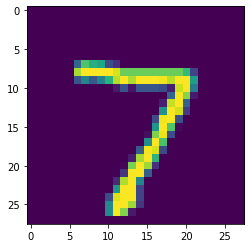

In [12]:
from matplotlib.pyplot import imshow
imshow(X_test[0])

In [13]:
N_EPOCH = 10
LR = 0.01
BS = 250

In [14]:
import torch
torch.set_printoptions(sci_mode=False)
# Feature Scaling
X_train_scaled = torch.tensor([np.reshape(xi/256, (-1)) for xi in X_train], dtype=torch.float32)
X_test_scaled = torch.tensor([np.reshape(xi/256, (-1, 28*28)) for xi in X_test], dtype=torch.float32)

# One-Hot encoded targets
y_train_one_hot = [[1 if i == l else 0 for i in range(10)] for l in y_train]
y_test_one_hot = [[1 if i == l else 0 for i in range(10)] for l in y_test]

y_train_torch = torch.tensor(y_train.copy())
y_test_torch = torch.tensor(y_test.copy())
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
train_ds = TensorDataset(X_train_scaled, y_train_torch)
test_ds = TensorDataset(X_test_scaled, y_test_torch)
train_dl = DataLoader(train_ds, BS, shuffle=True)
test_dl = DataLoader(test_ds)

In [15]:
import model
model = model.conNet()

In [16]:
import wandb
wandb.init(project="mnist", entity="0xasim")
wandb.config = {
  "learning_rate": LR,
  "epochs": N_EPOCH,
  "batch_size": BS
}
WAND = False

loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,1632.47305
test accuracy,0.98


In [17]:
def get_test_acc():
    with torch.no_grad():
        n_correct = 0
        for x, target in test_dl:
            # b_x = Variable(x)[0]
            b_x = x
            pred = model.forward(b_x)
            top_1 = torch.argmax(pred)
            n_correct += (top_1 == target)
        acc = n_correct[0]/10_00
        # print(f'accuracy: {acc/100}%')
        return acc

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from tqdm import tqdm
loss_hist = np.zeros(N_EPOCH)
accuracy_hist = np.zeros(N_EPOCH)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
for epoch in tqdm(range(N_EPOCH)):
    for x_batch, y_batch in train_dl:
        # print(pred[0], y_batch[0])
        # imshow((x_batch[0][0]*256).reshape(28,28))
        b_x = Variable(x_batch)
        b_y = Variable(y_batch)
        pred = model.forward(b_x)
        loss = loss_fn(pred, b_y)
        # clear gradients for this training step
        optimizer.zero_grad()
        # backprop, compute gradients
        loss.backward()
        # apply gradients
        optimizer.step()
        loss_hist[epoch] += loss.item()*y_batch.size()[0]
    if WAND:
        wandb.log({"loss": loss_hist[epoch]})
        wandb.log({"test accuracy": get_test_acc()})
print(loss_hist, get_test_acc())

[6899.69648048 6484.31933392 5662.18933091 5463.9911931  4862.81636835
 5081.22579602 4788.58502209 4283.66448742 3711.66278142 3188.73280066] tensor(0.9800)
